# Project Deep Learning - Fine-tuning Diffusion Model with LoRA

Author: Hoai-Nam NGUYEN

Date: 31/12/2023

# Packages preparation

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

#! pip install -q diffusers

import torch
import torchvision
from torch import nn
import torch.optim as optim
#from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

from matplotlib import pyplot as plt
import torchvision.transforms as transforms 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


# Data Loading 

The dataset I work with is CIFAR10. Downloading the training and test datasets can be done with 'torchvision.datase'. Applying transform while dowloading is to convert the images into pytorch tensors and normialize their piel values. Afterwards, I create dataloaders.

In [2]:
transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

In [3]:
# Download training set
trainset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, 
                                      transform=transform)

# Download test set
testset = torchvision.datasets.MNIST(root="mnist/", train=False, download=True, 
                                     transform=transform)

# Simple Convolutional Neural Networks

I create a simple CNN to classify the images. This CNN consists of two convolutional layers with maxpooling layers, flattening layer and dropout layer between, and then a three linear layers. This CNN will be utilized in the diffusion model during reverse process to sequentially denoise images. The linear layers are the layers that will eventually be replaced with LoRA layers.

In [4]:
class MNISTClassifier(nn.Module):

    '''
        A neural network model for classifying images from the MNIST dataset.

        Architecture:
            - Two convolutional layers (conv1 and conv2) with ReLU activation.
            - Max-pooling layer to reduce spatial dimensions.
            - Flattening layer to convert feature maps into a 1D vector.
            - Dropout layer with a dropout rate of 20% to prevent overfitting.
            - Three fully connected (linear) layers with ReLU activation.

        Input:
            - Grayscale images from the MNIST dataset.

        Output:
            - Classification into one of the 10 classes. 

    '''

    # Class constructor
    def __init__(self):
        super(MNISTClassifier, self).__init__()

        # write the model

        # two convolutional layers, conv1 and conv2 (with 32 inputs matching the output channels of conv1)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5), padding = 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5), padding = 2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=(5, 5), padding = 2)
        
        # Max-pooling layer reduces the spatial dimensions of the feature maps.
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten the feature maps into a 1D vector, connect the convolutional layers to the fully connected layers.
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)

        # dropout rate of 20% to prevent overfitting.
        self.dropout = nn.Dropout2d(p=0.2)

        # fully connected (linear) layers.
        self.linear1 = nn.Linear(in_features=576, out_features=288)
        self.linear2 = nn.Linear(in_features=288, out_features=144)
        self.linear3 = nn.Linear(in_features=144, out_features=72)
        self.linear4 = nn.Linear(in_features=72, out_features=10)
        

    def forward(self, x):
        # Implement the computation graph
        # Input data x is passed through the first convolutional layer with ReLU activation.
        x = torch.relu(self.conv1(x))
        x = self.pooling(x)

        # Input data x is passed through the second convolutional layer with ReLU activation.
        x = torch.relu(self.conv2(x))
        x = self.pooling(x)
        
        x = torch.relu(self.conv3(x))
        x = self.pooling(x)

        x = self.flatten(x)
        x = self.dropout(x)

        # The flattened tensor is passed through the fully connected layers with ReLU activation functions.
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = torch.relu(self.linear3(x))

        # The final output is the result of the third fully connected layer
        x = self.linear4(x)

        return x

In [5]:
MNISTClassifier() 

MNISTClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (linear1): Linear(in_features=576, out_features=288, bias=True)
  (linear2): Linear(in_features=288, out_features=144, bias=True)
  (linear3): Linear(in_features=144, out_features=72, bias=True)
  (linear4): Linear(in_features=72, out_features=10, bias=True)
)

In [6]:
def print_params(model: nn.Module):
    """
    Print the number of trainable and untrainable parameters in the model.

    Args:
        model: The model to print the parameters of.
    """
    trainable = 0  # number of trainable parameters
    untrainable = 0  # number of untrainable parameters
    trainable_size = 0  # size in mb of trainable parameters

    print("Layers:")
    for name, param in model.named_parameters():
        print(f"- {name} of size {param.size()} -> {'trainable' if param.requires_grad else 'untrainable'}")

        if param.requires_grad:  # if the parameter requires a gradient
            trainable += param.numel()  # increment the number of trainable parameters
            trainable_size += param.numel() * param.element_size()  # increment the size of trainable parameters
        else:  # otherwise
            untrainable += param.numel()  # increment the number of untrainable parameters

    print(f"\nTrainable parameters: {trainable}")
    print(f"Untrainable parameters: {untrainable}")
    print(f"Total parameters: {trainable + untrainable}")
    print(f"Percent trainable: {100 * trainable / (trainable + untrainable)}%")
    percentage = trainable_size / 1e6
    print(f"Size of trainable parameters: {percentage:.2f} mb")

In [7]:
net = MNISTClassifier() 
print_params(net)

Layers:
- conv1.weight of size torch.Size([32, 1, 5, 5]) -> trainable
- conv1.bias of size torch.Size([32]) -> trainable
- conv2.weight of size torch.Size([64, 32, 5, 5]) -> trainable
- conv2.bias of size torch.Size([64]) -> trainable
- conv3.weight of size torch.Size([64, 64, 5, 5]) -> trainable
- conv3.bias of size torch.Size([64]) -> trainable
- linear1.weight of size torch.Size([288, 576]) -> trainable
- linear1.bias of size torch.Size([288]) -> trainable
- linear2.weight of size torch.Size([144, 288]) -> trainable
- linear2.bias of size torch.Size([144]) -> trainable
- linear3.weight of size torch.Size([72, 144]) -> trainable
- linear3.bias of size torch.Size([72]) -> trainable
- linear4.weight of size torch.Size([10, 72]) -> trainable
- linear4.bias of size torch.Size([10]) -> trainable

Trainable parameters: 373522
Untrainable parameters: 0
Total parameters: 373522
Percent trainable: 100.0%
Size of trainable parameters: 1.49 mb


# Diffusion Model 

Diffusion models are a class of generative AI models that generate high-resolution images of varying quality. They work by gradually adding Gaussian noise to the original data in the forward diffusion process and then learning to remove the noise in the reverse diffusion process. They are latent variable models referring to a hidden continuous feature space, look similar to VAEs(Variational Autoencoders), and are loosely based on non-equilibrium thermodynamics.

<div>
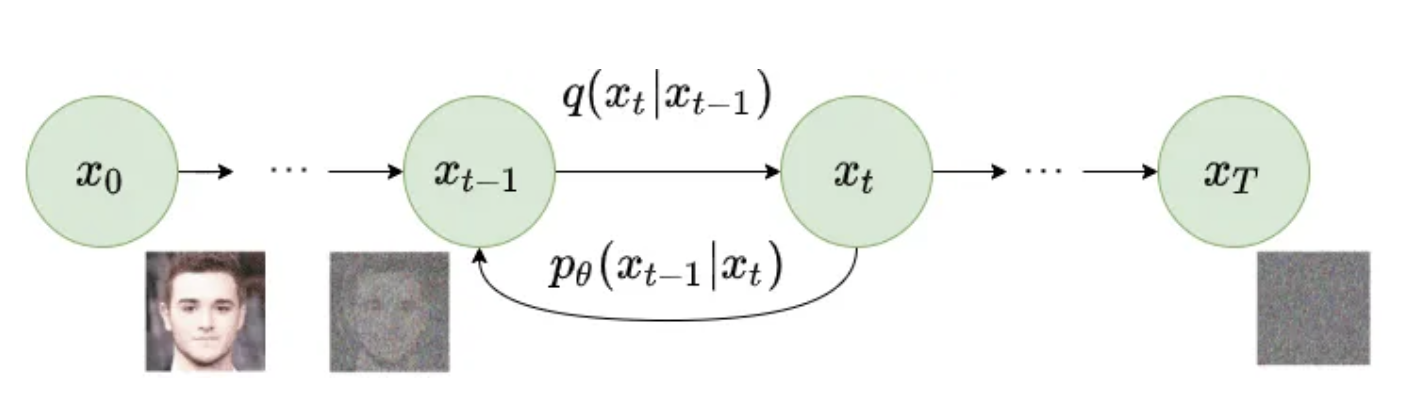
</div>

1. Forward diffusion process — The forward diffusion process is the Markov chain of diffusion steps in which we slowly and randomly add noise to the original data.

In the forward diffusion process, we slowly and gradually add Gaussian noise to the input image x₀ through a series of T steps. We start with sampling a data point $x_0$ from the real data distribution $q(x)$ like $(x_0 ~ q(x))$ and then adding some Gaussian noise with variance $\beta_t$ to $x_{t-1}$, producing a new latent variable $x_t$ with distribution $q(x_t∣x_{t-1})$

2. Reverse diffusion process — The reverse diffusion process tries to reverse the diffusion process to generate original data from the noise.

It is the process of training a neural network to recover the original data by reversing the noising process applied in the forward pass. Estimating $q(x_{t-1}|x_t)$ is difficult as it can require the whole dataset. That’s why a parameterized model $p_0$ (Neural Network) can be used to learn the parameters. For small enough $\beta_t$, it will be a Gaussian and can be obtained by just parameterizing the mean and variance.

In [8]:
class DiffusionModel(nn.Module):
    
    '''
        A Diffusion Model for image classification
        
        This model first adds Gaussian noise to blur images in corruption pass
        Afterward, it uses the CNN in the reverse process to sequentially denoise images 
        
    '''
    def __init__(self, train_dataloader, test_dataloader, classes, net, device="cpu"):
        super(DiffusionModel, self).__init__()

        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.device = device
        
        self.classes = classes

        # Create the network
        self.net = net 
        self.net.to(device)

        # Loss function
        self.loss_fn = nn.CrossEntropyLoss()

        # The ptimizer
        self.optimizer = optim.Adam(self.net.parameters(), lr=1e-3)

        # Keeping a record of the losses for later viewing
        self.losses = []

    # A corruption process adds the noise to the input images. 
    def corrupt(self, x, amount):
        
        # Create a random noise with the same size as input
        noise = torch.rand_like(x)
        
        # Sort shape so broadcasting works
        amount = amount.view(-1, 1, 1, 1)
        
        # Add noise to the input images
        return x * (1 - amount) + noise * amount

    # Training model
    def train_model(self, n_epochs=3):
        
        # The training loop
        for epoch in range(n_epochs):
            
            for data in self.train_dataloader:
                
                # Get data and prepare the corrupted version
                inputs, labels = data[0].to(device), data[1].to(device)  # get inputs and labels
                
                # Pick random noise amounts
                noise_amount = torch.rand(inputs.shape[0]).to(self.device)  
                
                # Create noisy x
                noisy_inputs = self.corrupt(inputs, noise_amount)  

                # Get the model prediction
                pred = self.net(noisy_inputs)
                
                # Calculate the loss
                loss = self.loss_fn(pred, labels)
                
                # Backward pass and update the params:
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                # Store the loss for later
                self.losses.append(loss.item())
                
            # Print out the average of the loss values for this epoch:
            avg_loss = sum(self.losses[-len(self.train_dataloader):]) / len(self.train_dataloader)
            print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:.5f}')
    
    # Visualize some trained results.
    def viz(self):
        
        # Fetch some data
        inputs, labels = next(iter(self.train_dataloader))
        inputs = inputs[:5] 
        
        # Corrupt with a range of amounts
        amount = torch.linspace(0, 1, inputs.shape[0]) # Left to right -> more corruption
        noised_inputs = self.corrupt(inputs, amount)
        
        # Get the model predictions
        with torch.no_grad():
            preds = self.net(noised_inputs.to(self.device)).detach().cpu()
            
        # Plot
        fig, axs = plt.subplots(3, 1, figsize=(12, 7))
        axs[0].set_title('Input data')
        axs[0].imshow(torchvision.utils.make_grid(inputs)[0].clip(0, 1), cmap = 'Greys')
        axs[1].set_title('Corrupted data')
        axs[1].imshow(torchvision.utils.make_grid(noised_inputs)[0].clip(0, 1), cmap = 'Greys')
        axs[2].set_title('Network Predictions')
        axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap = 'Greys');
    
    # Test the performance of trained model on the testing set 
    def test_model(self):
        
        correct = 0
        total = 0
        
        # Don't compute gradients
        with torch.no_grad(): 
            
            # Iterate over data
            for data in self.test_dataloader: 
                
                # get inputs and labels
                inputs, labels = data[0].to(self.device), data[1].to(self.device) 
                
                # Pick random noise amounts
                noise_amount = torch.rand(inputs.shape[0]).to(self.device)  
                
                # Create noisy x
                noisy_inputs = self.corrupt(inputs, noise_amount) 
                
                # Get the network's predictions
                pred = self.net(noisy_inputs) 
                
                # get the class with the highest score
                _, predicted = torch.max(pred.data, 1) 
                
                # increment total by the number of labels
                total += labels.size(0) 
                
                # increment correct by the number of correct predictions
                correct += (predicted == labels).sum().item() 

                    
        print(f"Accuracy of the network on the test images: {100 * correct / total}%\n")
        
    def save_weights(self, filename):
        torch.save(self.net.state_dict(), filename)

    def load_weights(self, filename):
        self.net.load_state_dict(torch.load(filename))

# Fine-tuning diffusion model without LoRA as Baselines

I first train diffusion model on first half of the data. I then use the pre-trained weights to train diffusion model on the remaining half of the data. I train the model on the new data on exactly one element once. My model performs poorly on the new data that it hasn't seen, which is unsuprising. Afterwards, I finetune the model on the new data. Unsuprisingly finetuning allows to perform equally well on the second half of MNIST. However this approach would require us to save the entire model binary for each dataset we wanted to finetune our initial model on, which doesn't scale well.

## 1. Train diffusion model on first half of the training data

In [9]:
def get_indices(dataset, class_names):
    
    ''' Get the indices of samples in a dataset corresponding to specified class names '''
    
    if isinstance(dataset, torch.utils.data.dataset.Subset):
        targets = torch.tensor([dataset.dataset.targets[i] for i in dataset.indices])
    else:
        targets = dataset.targets

    indices = []
    for i in range(len(targets)):
        if targets[i] in class_names:
            indices.append(i)
    return indices

def create_dataloader(dataset, batch_size, class_names):
    
    ''' Create a DataLoader for a subset of a dataset containing specific class samples '''
    
    idx = get_indices(dataset, class_names)
    loader = DataLoader(dataset, 
                        batch_size = batch_size, 
                        sampler = SubsetRandomSampler(idx), 
                        num_workers=4
                       ) 
    return loader

In [10]:
# Define the first five class of the training data 
class_names = [0,1,2,3,4]

# Load data in batchs
batch_size = 32
train_dataloader_1 = create_dataloader(trainset, batch_size, class_names)
test_dataloader_1 = create_dataloader(testset, batch_size, class_names)

In [13]:
# Train diffusion model on the first half of the data

diffusion_model = DiffusionModel(train_dataloader_1, test_dataloader_1, class_names, net, device="cpu")
diffusion_model.train_model(n_epochs=3)

/Users/hoainam/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Finished epoch 0. Average loss for this epoch: 0.30724
Finished epoch 1. Average loss for this epoch: 0.14585
Finished epoch 2. Average loss for this epoch: 0.12940


In [14]:
# Save weights trained on the first half of training set

diffusion_model.save_weights("diffusion_model_weights_half.pth")

## 2. Evaluate the performance on the first half of test set 

In [15]:
diffusion_model.test_model()

Accuracy of the network on the test images: 96.244405526367%



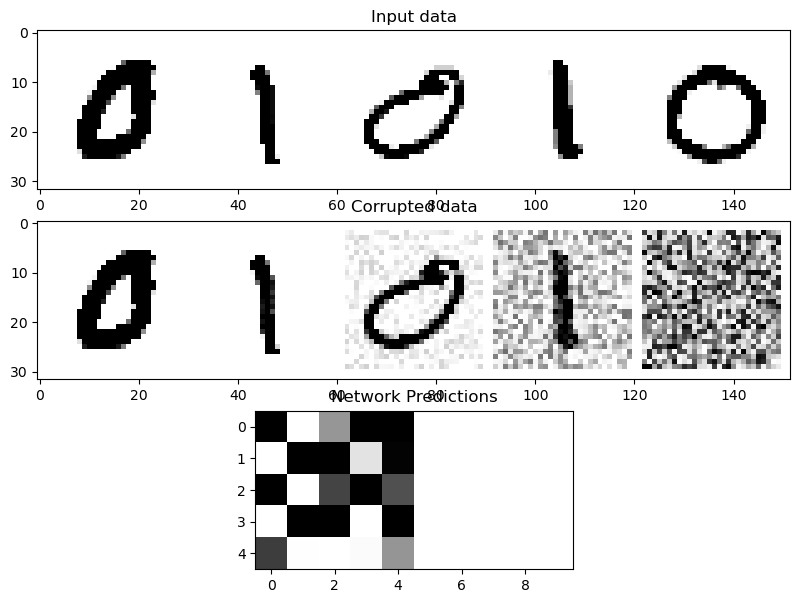

In [16]:
diffusion_model.viz()

## 3. Finetuning on second half of the training set

### 3.1. No training on the new data

In [17]:
# Define the second five class of the training data 
class_names = [5,6,7,8,9]

# Train the model on the new data on exactly one element once using weights trained on the first half of the data
batch_size = 1

train_dataloader_2 = create_dataloader(trainset, batch_size, class_names)
test_dataloader_2 = create_dataloader(testset, batch_size, class_names)

diffusion_model.load_weights("diffusion_model_weights_half.pth")
diffusion_model.train_dataloader = train_dataloader_2
diffusion_model.train_model(n_epochs=1) 

Finished epoch 0. Average loss for this epoch: 0.39269


In [18]:
# Evaluate on the test set 

diffusion_model.test_dataloader = test_dataloader_2
diffusion_model.classes = class_names
diffusion_model.test_model() 

Accuracy of the network on the test images: 91.91524377700061%



### 3.2. Finetuning on the new data

In [19]:
# Fine-tuning on the half class of the training data with the same batch as on the first half of the data

class_names = [5,6,7,8,9]

batch_size = 32

train_dataloader_2 = create_dataloader(trainset, batch_size, class_names)
test_dataloader_2 = create_dataloader(testset, batch_size, class_names)

diffusion_model.load_weights("diffusion_model_weights_half.pth")
diffusion_model.train_dataloader = train_dataloader_2
diffusion_model.train_model(n_epochs=3) 

Finished epoch 0. Average loss for this epoch: 0.46711
Finished epoch 1. Average loss for this epoch: 0.20705
Finished epoch 2. Average loss for this epoch: 0.18237


In [20]:
# Evaluate on the test set. The performance is better than the previous case 

diffusion_model.test_dataloader = test_dataloader_2
diffusion_model.classes = class_names
diffusion_model.test_model() 

Accuracy of the network on the test images: 94.07529314955771%



# Fine-tuning diffusion model with LoRA

The principle of the method resides in rank property. Given a matrix A of shape m x n, we have the following property: $$rank(A)\leq min(m,n)$$
In case of equality, we say A is full-rank matrix, otherwise A is rank-deficient matrix. Another theoritical property support this method is that every finite matrix has a rank decomposition (SVD): $$ A_{mn} = C_{mr}F_{rn}, rank(A) = r $$

In term of deep learning, a neural networls (NN) contains many dense layers which perform matrix multiplication. The weight matrices in these layers typically have full-rank. Many studies showed that we can learn efficiently over-parameterized models thanks to a low 'intrinsic dimension'. LoRA applies this approach basing on the assumption that updates to the weight also have a low 'intrinsic rank' during adaptation. Effectively, while large models are trained to capture a variety of features, adaptation of a these models to a specific task or dataset requires only a few features to be emphasized or re-learnt. If $W_{nk}$ is weights of a single layer and $\Delta W_{nk}$ is change of weights during model adaptation then $\Delta W_{nk}$ is a low-rank matrix, i.e. $rank(\Delta W_{nk}) << min(n,k)$.

Traditional fine-tuning trains a subset of the pre-trained parameters. During the fine-tuning, model is initialized to the pre-trained weights and biases and all model parameters undergo gradient updates to have full-rank during adaptation, which is expensive.

On the other hand, fine-tuning by LoRA does not need to calculate the gradient for vast majority of paramaters. LoRA consist in training some dense layers in neural networks indirectly by optimizing rank decomposition matrices of the dense layer's change during adaptation, while keeping the pre-trained weights frozen. Training LoRA roughly converges to training the original model. 

The following figure from the paper illustrates how LoRA works. 

<div>
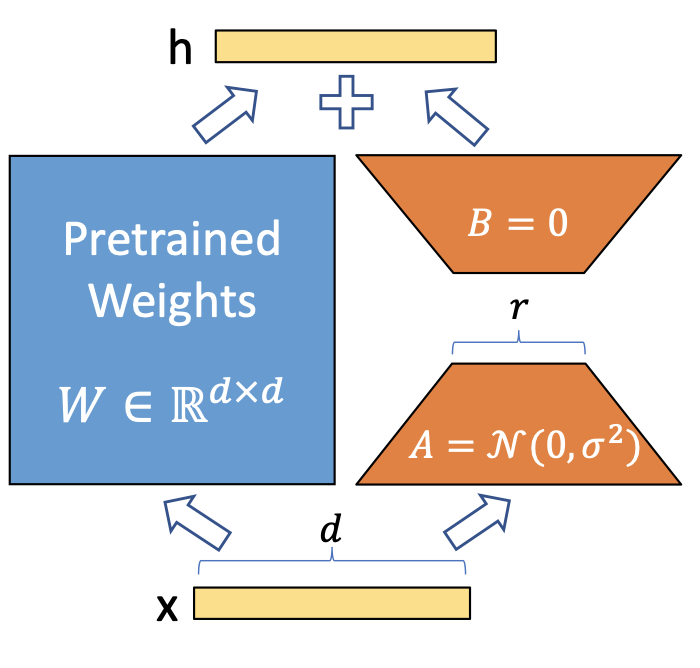


In particular, we keep the weight matrix and the change-in-weights matrix seperate throughout the fine-tuning process. The forward pass becomes $h = Wx + \Delta Wx$. While in traditional fine-tuning, we update $W$ through backward propagation by negative gradient descent, LoRA frozens and does not change these weights. We updates instead the change-in-weights $\Delta W$. Denotes for simplicity $W_\phi$ as change-in-weight matrix, we have instead:
$$ W'_\phi = W_\phi + \Delta W_\phi$$

LoRA goes further by approximating the change-in-weight matrix $W_\phi$ with the product of two lower-rank matrices $A$ and $B$, 

$$ h = Wx + W_\phi x = Wx + BAx $$

The beauty of this method is that B and A are parameterized. We do not have to solve for them with matrix decomposition algorithms or anything. The contents of B and A are learned during the fine-tuning process. Furthermore, after the weights of B and A are learned, the BA matrix can be merged back with the frozen weights thrugh simple addition. 

Notes that matrice B is initialized to all zeros because we want B multiplied with A to also be zero and have no effect on the weight matrix for the very first forward pass of the fine-tuning process. 

Fine-tuning with LoRA have some advantages over with full fine-tuning: there is no additional inference latency, it reduce storage requirement and task-switching over-head significantly, it uses adaptative optimizers to render training efficient and lower handware barrier. 

In [21]:
class LoRALinear(nn.Module):
    """
    Low-rank adapted linear layer

    Args:
      module: The linear layer module to adapt.
      rank: The rank of the approximation.
      alpha: The alpha parameter.
      dropout: The dropout probability between 0 and 1
    """
    
    def __init__(
        self,
        module: nn.Module,
        
        rank: int = 4,
        alpha: float = 4.0,
        dropout: float = 0.2
        
    ):

        super().__init__()
        self.rank = rank  
        self.alpha = alpha  
        self.dropout = nn.Dropout(dropout) 
        
        self.in_dim = module.in_features  
        self.out_dim = module.out_features  

        # make sure that rank is at least 1
        assert self.rank >= 1, "Rank must be at least 1."

        # recreate the linear layer 
        self.pretrained = nn.Linear(self.in_dim, self.out_dim, bias=True)
        
        self.pretrained.weight = nn.Parameter(module.weight.detach().clone())
        self.pretrained.bias = nn.Parameter(module.bias.detach().clone())
        
        # freeze the weights and the bias
        self.pretrained.weight.requires_grad = False  
        self.pretrained.bias.requires_grad = False  

        # create the A and initialize with Kaiming
        self.A = nn.Linear(self.in_dim, rank, bias=False)
        nn.init.kaiming_uniform_(self.A.weight, a=math.sqrt(5))

        # create B and initialize with zeros
        self.B = nn.Linear(rank, self.out_dim, bias=False)
        nn.init.zeros_(self.B.weight)
        
        # scaling constant
        self.scaling = self.alpha / self.rank  

        # ensure that the weights in A and B are trainable
        self.A.weight.requires_grad = True
        self.B.weight.requires_grad = True

    def forward(self, x: torch.Tensor):
        """
        Perform the forward pass of the layer.

        Args:
          x: The input tensor.
        """
        pretrained_out = self.pretrained(x)  # Wx
        
        lora_out = self.dropout(x) 
        lora_out = self.A(x)
        lora_out = self.B(lora_out) # BAx
        lora_out = lora_out * self.scaling
        
        return pretrained_out + lora_out # W0x + BAx

In [22]:
# Print the number of trainable and untrainable parameters in the model

print_params(net) 

Layers:
- conv1.weight of size torch.Size([32, 1, 5, 5]) -> trainable
- conv1.bias of size torch.Size([32]) -> trainable
- conv2.weight of size torch.Size([64, 32, 5, 5]) -> trainable
- conv2.bias of size torch.Size([64]) -> trainable
- conv3.weight of size torch.Size([64, 64, 5, 5]) -> trainable
- conv3.bias of size torch.Size([64]) -> trainable
- linear1.weight of size torch.Size([288, 576]) -> trainable
- linear1.bias of size torch.Size([288]) -> trainable
- linear2.weight of size torch.Size([144, 288]) -> trainable
- linear2.bias of size torch.Size([144]) -> trainable
- linear3.weight of size torch.Size([72, 144]) -> trainable
- linear3.bias of size torch.Size([72]) -> trainable
- linear4.weight of size torch.Size([10, 72]) -> trainable
- linear4.bias of size torch.Size([10]) -> trainable

Trainable parameters: 373522
Untrainable parameters: 0
Total parameters: 373522
Percent trainable: 100.0%
Size of trainable parameters: 1.49 mb


In [23]:
# Freeze all parameters in the model.
for param in net.parameters(): 
        param.requires_grad = False 
print_params(net)

print('\n')

# Unfreeze all parameters in the model.
for param in net.parameters(): 
        param.requires_grad = True 
print_params(net)

Layers:
- conv1.weight of size torch.Size([32, 1, 5, 5]) -> untrainable
- conv1.bias of size torch.Size([32]) -> untrainable
- conv2.weight of size torch.Size([64, 32, 5, 5]) -> untrainable
- conv2.bias of size torch.Size([64]) -> untrainable
- conv3.weight of size torch.Size([64, 64, 5, 5]) -> untrainable
- conv3.bias of size torch.Size([64]) -> untrainable
- linear1.weight of size torch.Size([288, 576]) -> untrainable
- linear1.bias of size torch.Size([288]) -> untrainable
- linear2.weight of size torch.Size([144, 288]) -> untrainable
- linear2.bias of size torch.Size([144]) -> untrainable
- linear3.weight of size torch.Size([72, 144]) -> untrainable
- linear3.bias of size torch.Size([72]) -> untrainable
- linear4.weight of size torch.Size([10, 72]) -> untrainable
- linear4.bias of size torch.Size([10]) -> untrainable

Trainable parameters: 0
Untrainable parameters: 373522
Total parameters: 373522
Percent trainable: 0.0%
Size of trainable parameters: 0.00 mb


Layers:
- conv1.weight 

In [24]:
def update_model(model: nn.Module, rank: int = 4, alpha: float = 4.0, dropout: float = 0.2, device: str = 'cpu'):
  
    """
      Replaces all linear layers in the model with LoRALinear layers.
  
      Args:
        model: The model to update.
        rank: The rank of the approximation.
        alpha: The alpha parameter.
        dropout: The dropout probability
      """
    
    # Freeze all parameters in the model.
    for param in model.parameters(): 
        param.requires_grad = False
    
    # Iterate over the children of the model
    for name, module in model.named_children(): 
        
        # If the module is a linear layer
        if isinstance(module, nn.Linear): 
            
            # Replace it with a LoRALinear layer
            setattr(model, name, LoRALinear(module, rank, alpha)) 
            print(f"Replaced {name} with LoRALinear layer.")
            
        # Otherwise
        else: 
            
            # Recursively call the function on the module
            update_model(module, rank, alpha) 

    # Move the model to the device
    model.to(device)

    # Ensure low-rank matrices are trainable
    for name, module in model.named_modules():
        if isinstance(module, LoRALinear):
            module.A.weight.requires_grad = True
            module.B.weight.requires_grad = True

In [25]:
# Update the model
update_model(net, device=device) 

# Print the number of parameters
print_params(net) 

Replaced linear1 with LoRALinear layer.
Replaced linear2 with LoRALinear layer.
Replaced linear3 with LoRALinear layer.
Replaced linear4 with LoRALinear layer.
Layers:
- conv1.weight of size torch.Size([32, 1, 5, 5]) -> untrainable
- conv1.bias of size torch.Size([32]) -> untrainable
- conv2.weight of size torch.Size([64, 32, 5, 5]) -> untrainable
- conv2.bias of size torch.Size([64]) -> untrainable
- conv3.weight of size torch.Size([64, 64, 5, 5]) -> untrainable
- conv3.bias of size torch.Size([64]) -> untrainable
- linear1.pretrained.weight of size torch.Size([288, 576]) -> untrainable
- linear1.pretrained.bias of size torch.Size([288]) -> untrainable
- linear1.A.weight of size torch.Size([4, 576]) -> trainable
- linear1.B.weight of size torch.Size([288, 4]) -> trainable
- linear2.pretrained.weight of size torch.Size([144, 288]) -> untrainable
- linear2.pretrained.bias of size torch.Size([144]) -> untrainable
- linear2.A.weight of size torch.Size([4, 288]) -> trainable
- linear2.B.we

In [26]:
# Train diffusion model with LoRA on second half of the data set.

# Define the class names of the second half of the data set
class_names = [5,6,7,8,9]

# Defind the batch size
batch_size = 32

# Load the training and test data in batchs
train_dataloader_2 = create_dataloader(trainset, batch_size, class_names)
test_dataloader_2 = create_dataloader(testset, batch_size, class_names)

# Load the weight
state_dict = torch.load("diffusion_model_weights_half.pth")

# Train duffusion model with LoRA
diffusion_model_LoRA = DiffusionModel(train_dataloader_2, test_dataloader_2, class_names, net, device="cpu")
diffusion_model_LoRA.load_state_dict(state_dict, strict=False)
diffusion_model_LoRA.train_model(n_epochs=3)

Finished epoch 0. Average loss for this epoch: 0.15274
Finished epoch 1. Average loss for this epoch: 0.15191
Finished epoch 2. Average loss for this epoch: 0.14786


In [27]:
# Double check the params
print_params(net)

# Some of the A and B matrices should have changed. It is expected to have B weights are non-zero. 

for name, param in net.named_parameters():
  if 'B.weight' in name:
    print(f"{name} has all zero weights: {torch.all(param == 0)}")

Layers:
- conv1.weight of size torch.Size([32, 1, 5, 5]) -> untrainable
- conv1.bias of size torch.Size([32]) -> untrainable
- conv2.weight of size torch.Size([64, 32, 5, 5]) -> untrainable
- conv2.bias of size torch.Size([64]) -> untrainable
- conv3.weight of size torch.Size([64, 64, 5, 5]) -> untrainable
- conv3.bias of size torch.Size([64]) -> untrainable
- linear1.pretrained.weight of size torch.Size([288, 576]) -> untrainable
- linear1.pretrained.bias of size torch.Size([288]) -> untrainable
- linear1.A.weight of size torch.Size([4, 576]) -> trainable
- linear1.B.weight of size torch.Size([288, 4]) -> trainable
- linear2.pretrained.weight of size torch.Size([144, 288]) -> untrainable
- linear2.pretrained.bias of size torch.Size([144]) -> untrainable
- linear2.A.weight of size torch.Size([4, 288]) -> trainable
- linear2.B.weight of size torch.Size([144, 4]) -> trainable
- linear3.pretrained.weight of size torch.Size([72, 144]) -> untrainable
- linear3.pretrained.bias of size torch.

In [28]:
# Fine-tuning diffusion model with LoRA gives roughly the same result as with the whole parameters. 

diffusion_model_LoRA.test_model()

Accuracy of the network on the test images: 94.52787492285537%



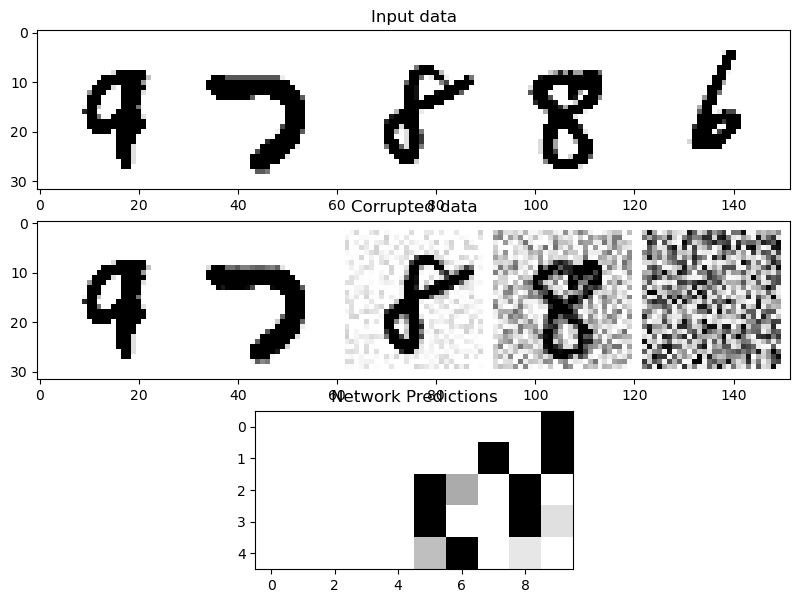

In [29]:
diffusion_model_LoRA.viz()

# References

Georges David, More Efficient Finetuning: Implementing LoRA from Scratch, https://www.linkedin.com/pulse/more-efficient-finetuning-implementing-lora-from-scratch-george-davis/

Hugging Face, Diffusion Model from Scratch, https://github.com/huggingface/diffusion-models-class/blob/main/unit1/02_diffusion_models_from_scratch.ipynb

Sunil Kumar, LoRA from Scratch, https://github.com/sunildkumar/lora_from_scratch/tree/main

Kailash Ahirwar, A Very Short Introduction to Diffusion Models, https://kailashahirwar.medium.com/a-very-short-introduction-to-diffusion-models-a84235e4e9ae

Edward J. Hu, Yelong Shen, Phillip Wallis, Zeyuan Allen-Zhu, Yuanzhi Li, Shean Wang, Lu Wang, Weizhu Chen, LoRA: Low-Rank Adaptation of Large Language Models, https://arxiv.org/abs/2106.09685

Nikhil Nagaraj, Low Rank Adaptation: A Technical Deep Dive, https://www.ml6.eu/blogpost/low-rank-adaptation-a-technical-deep-dive

AR, LoRA: Low-Rank Adaptation from Scratch — Code and Theory, https://medium.com/@alexmriggio/lora-low-rank-adaptation-from-scratch-code-and-theory-f31509106650
